In [1]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../MAE589Project/package/helper/')
sys.path.append('../MAE589Project/package/mujoco_usage/')
sys.path.append('../MAE589Project/package/gpt_usage/')
sys.path.append('../MAE589Project/package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

c:\Users\qfonn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready.


In [1]:
import mujoco as mj
import imageio
from mujoco.glfw import glfw
import numpy as np
import sys
import os
from OpenGL import GL
import matplotlib.pyplot as plt  # for visualization

# Add your sim_utils and Functions paths
sim_utils_path = sys.path.append('../MAE589Project')
if sim_utils_path not in sys.path:
    sys.path.append(sim_utils_path)
import sim_utils
import Functions as F

# XML model path
xml_path = 'franka_panda_w_objs.xml'
simend = 300

# --- Your RobotController class remains unchanged ---
class RobotController:
    def __init__(self, ee_site_id, target_body_id):
        self.ee_site_id = ee_site_id
        self.target_body_id = target_body_id
        self.current_step = 0
        self.gripper_open = False
        self.wait_duration = 5
        self.wait_timer = 0.0
        self.waiting = False

        self.steps = [
            self.step_move_above_block,
            self.step_open_gripper,
            self.step_wait_after_open,
            self.step_move_middle_block,
            self.step_move_hold_clamp,
            self.step_move_it
        ]

    def step_move_above_block(self, box_pos): return box_pos + np.array([0.0, 0.0, 0.10])
    def step_move_it(self, box_pos): return box_pos + np.array([0.03, 0.0, 0.0])
    def step_move_up(self, box_pos): return box_pos + np.array([0.03, 0.1, 0.0])
    def step_open_gripper(self, box_pos): return box_pos + np.array([0.03, 0.0, 0.10])
    def step_wait_after_open(self, box_pos): return box_pos + np.array([0.03, 0.0, 0.10])
    def step_move_middle_block(self, box_pos): return box_pos + np.array([0.03, 0.0, 0.0])
    def step_close_gripper(self, box_pos): return box_pos + np.array([0.03, 0.0, 0.0])
    def step_move_hold_clamp(self, box_pos): return box_pos

    def controller(self, model, data):
        nv = model.nv
        ee_pos = data.site_xpos[self.ee_site_id].copy()
        R_ee = data.site_xmat[self.ee_site_id].reshape(3, 3)
        box_pos = data.xpos[self.target_body_id].copy()

        target_pos = self.steps[self.current_step](box_pos)

        if self.waiting:
            self.wait_timer += model.opt.timestep
            if self.wait_timer >= self.wait_duration:
                self.waiting = False
                self.wait_timer = 0.0
                self.current_step += 1
        else:
            pos_err = target_pos - ee_pos
            if np.linalg.norm(pos_err) < 0.03:
                if self.steps[self.current_step] in [self.step_wait_after_open, self.step_move_hold_clamp]:
                    self.waiting = True
                    self.wait_timer = 0.0
                else:
                    if self.current_step < len(self.steps) - 1:
                        self.current_step += 1

        self.gripper_open = self.steps[self.current_step] in [
            self.step_open_gripper, self.step_wait_after_open, self.step_move_middle_block
        ]

        R_box = data.xmat[self.target_body_id].reshape(3, 3)
        R_box_rot = R_box @ F.RotX(np.pi / 2) @ F.RotY(-np.pi / 2)

        pos_err = target_pos - ee_pos
        R_err = 0.5 * (np.cross(R_ee[:, 0], R_box_rot[:, 0]) +
                       np.cross(R_ee[:, 1], R_box_rot[:, 1]) +
                       np.cross(R_ee[:, 2], R_box_rot[:, 2]))
        error = np.hstack((pos_err, R_err))

        Jp = np.zeros((3, nv))
        Jr = np.zeros((3, nv))
        mj.mj_jacSite(model, data, Jp, Jr, self.ee_site_id)
        J_full = np.vstack((Jp, Jr))

        lam = 1e-3 + 1e-2 * np.linalg.norm(pos_err)
        A = J_full @ J_full.T + lam * np.eye(6)
        try:
            dq = J_full.T @ np.linalg.solve(A, error)
        except np.linalg.LinAlgError:
            dq = J_full.T @ np.linalg.pinv(A) @ error

        max_dq_norm = 0.2
        if np.linalg.norm(dq) > max_dq_norm:
            dq *= max_dq_norm / np.linalg.norm(dq)

        dq_step = 0.25 * dq
        q = data.qpos[:nv].copy()
        q_des = q + dq_step

        # Gripper control
        q_des[7] = np.pi if self.gripper_open else 0.0
        q_des[8] = -np.pi if self.gripper_open else 0.0

        Kp, Kd = 200, 10
        q_err = q_des - q
        qd = data.qvel[:nv].copy()
        f = data.qfrc_bias.copy()
        tau = (Kp * q_err) + (Kd * (-qd)) + f
        tau = np.clip(tau, -100.0, 100.0)
        data.qfrc_applied[:] = tau

# Load model and data
model = mj.MjModel.from_xml_path(xml_path)
data = mj.MjData(model)

# Cameras
main_cam = mj.MjvCamera()
rgbd_cam = mj.MjvCamera()
mj.mjv_defaultCamera(main_cam)
mj.mjv_defaultCamera(rgbd_cam)

# Set main camera position
main_cam.azimuth = 90
main_cam.elevation = -15
main_cam.distance = 2.5
main_cam.lookat = np.array([0.0, 0.0, 1.0])

# GLFW setup (unchanged)
if not glfw.init():
    raise Exception("GLFW init failed")
win_width, win_height = 1280, 480  # side-by-side window
window = glfw.create_window(win_width, win_height, "Simulation + RGB-D Side-by-Side", None, None)
if not window:
    glfw.terminate()
    raise Exception("GLFW window creation failed")

glfw.make_context_current(window)
glfw.swap_interval(1)

context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# Options and scenes
opt = mj.MjvOption()
scene_main = mj.MjvScene(model, maxgeom=10000)
scene_rgbd = mj.MjvScene(model, maxgeom=10000)

# IDs
ee_site_id = model.site("grip_site").id
target_body_id = model.body("obj_box_06").id
right_hand_body_id = model.body("right_hand").id

controller_obj = RobotController(ee_site_id, target_body_id)
mj.set_mjcb_control(controller_obj.controller)

# Setup input callbacks
glfw.set_key_callback(window, sim_utils.keyboard(model, data))
glfw.set_mouse_button_callback(window, sim_utils.mouse_button())
glfw.set_cursor_pos_callback(window, sim_utils.mouse_move(model, scene_main, main_cam))
glfw.set_scroll_callback(window, sim_utils.scroll(model, scene_main, main_cam))

# Right-hand camera update function (unchanged)
def update_right_hand_camera(model, data, cam, right_hand_body_id):
    body_pos = data.xpos[right_hand_body_id].copy()
    body_rot = data.xmat[right_hand_body_id].reshape(3, 3)
    offset = body_rot @ np.array([-0.2, 0.4, 0.5])
    cam.lookat = body_pos
    cam.distance = np.linalg.norm(offset)
    dx, dy, dz = offset
    cam.azimuth = np.degrees(np.arctan2(dy, dx)) + 90
    cam.elevation = np.degrees(np.arctan2(dz, np.linalg.norm([dx, dy])))

# --- New: Function to grab egocentric RGB and depth images from a camera ---
def get_egocentric_rgbd(model, data, cam, context, width=320, height=240, fovy=45):
    # Set camera parameters (azimuth, elevation, distance, lookat) before calling this function

    # Set FOV if supported
    if hasattr(cam, 'fovy'):
        cam.fovy = fovy

    # Update scene for this camera
    opt = mj.MjvOption()
    scene = mj.MjvScene(model, maxgeom=10000)
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)

    # Create buffer for rgb and depth
    rgb_buffer = (GL.GLubyte * (width * height * 3))()
    depth_buffer = (GL.GLfloat * (width * height))()

    # Render to buffers using OpenGL Framebuffer
    mj.mjr_render(mj.MjrRect(0, 0, width, height), scene, context)

    # Read pixels from OpenGL buffers
    GL.glReadPixels(0, 0, width, height, GL.GL_RGB, GL.GL_UNSIGNED_BYTE, rgb_buffer)
    GL.glReadPixels(0, 0, width, height, GL.GL_DEPTH_COMPONENT, GL.GL_FLOAT, depth_buffer)

    # Convert buffers to numpy arrays and flip vertically
    rgb_img = np.frombuffer(rgb_buffer, dtype=np.uint8).reshape((height, width, 3))[::-1, :, :]
    depth_img = np.frombuffer(depth_buffer, dtype=np.float32).reshape((height, width))[::-1, :]

    return rgb_img, depth_img


# --- New: Convert depth + camera intrinsics to point cloud ---
def depth_to_pointcloud(depth, fovy_deg=45):
    h, w = depth.shape
    fovy = np.deg2rad(fovy_deg)
    fx = fy = 0.5 * w / np.tan(fovy / 2)
    cx = w / 2
    cy = h / 2

    indices = np.indices((h, w), dtype=np.float32)
    x_indices = indices[1]
    y_indices = indices[0]

    z = depth
    x = (x_indices - cx) * z / fx
    y = (y_indices - cy) * z / fy
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)
    return points

# Flag to capture only once after 10 seconds
captured = False

while not glfw.window_should_close(window):
    simstart = data.time
    while data.time - simstart < 1.0 / 60.0:
        mj.mj_step(model, data)
    if data.time >= simend:
        break

    # Update main camera scene
    mj.mjv_updateScene(model, data, opt, None, main_cam, mj.mjtCatBit.mjCAT_ALL.value, scene_main)
    # Update right hand camera
    update_right_hand_camera(model, data, rgbd_cam, right_hand_body_id)
    mj.mjv_updateScene(model, data, opt, None, rgbd_cam, mj.mjtCatBit.mjCAT_ALL.value, scene_rgbd)

    # Clear screen
    GL.glClear(GL.GL_COLOR_BUFFER_BIT | GL.GL_DEPTH_BUFFER_BIT)

    # Left viewport - main camera
    GL.glViewport(0, 0, win_height, win_height)
    mj.mjr_render(mj.MjrRect(0, 0, win_width // 2, win_height), scene_main, context)

    # Right viewport - right hand camera
    GL.glViewport(win_width // 2, 0, win_width // 2, win_height)
    mj.mjr_render(mj.MjrRect(win_width // 2, 0, win_width // 2, win_height), scene_rgbd, context)

    glfw.swap_buffers(window)
    glfw.poll_events()

    # Capture and show image **once** after 10 seconds
    if not captured and data.time >= 10.0:
        rgb_img, depth_img = get_egocentric_rgbd(model, data, rgbd_cam, context, width=320, height=240, fovy=45)
        pcd = depth_to_pointcloud(depth_img, fovy_deg=45)
        h,w=depth_img.shape
        xyz_img_world=pcd.reshape(h,w,3)
        # Save RGB image as PNG
        imageio.imwrite("egocentric_rgb_10s.png", rgb_img)

        print(f"Saved egocentric RGB image at 10s as 'egocentric_rgb_10s.png'")
        captured = True  # prevent further capture

glfw.terminate()
print("Simulation finished.")


: 

In [3]:
png_path = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\notebook\egocentric_rgb_10s.png"
imageio.imwrite(png_path, rgb_img)
print(f"Saved egocentric RGB image at 10s as '{png_path}'")


Saved egocentric RGB image at 10s as 'C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\notebook\egocentric_rgb_10s.png'


In [4]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = r"C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt",
)
print ("Ready.")

key_path:[C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-anot
her-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


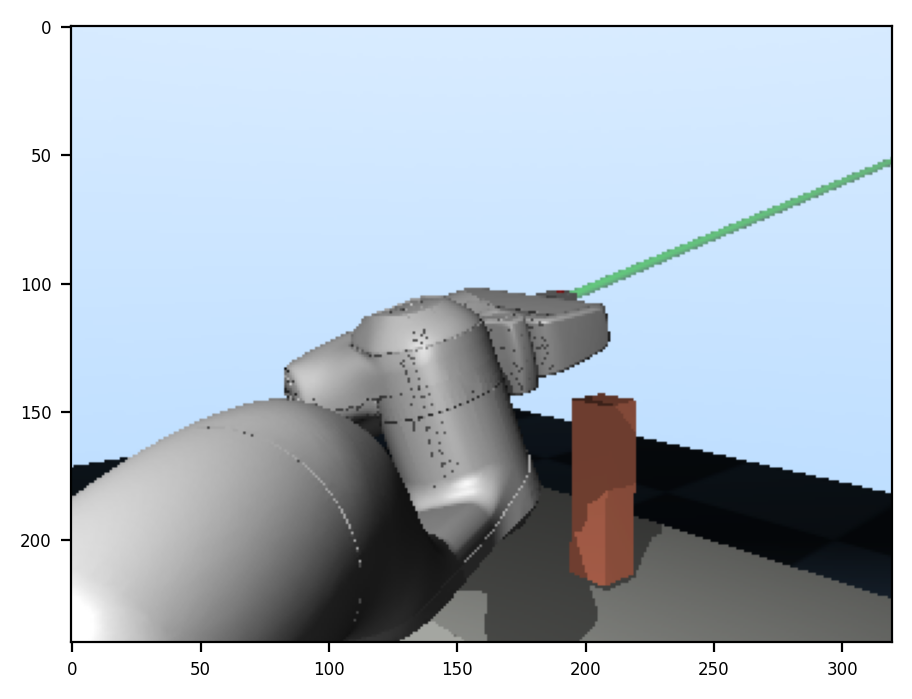

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image features a robotic arm extending towards a small brown object. A green laser or beam appears to be pointing from the arm toward the object. The scene is set against a simple backdrop with a gradient blue sky and a checkered floor. The robotic arm is metallic and has a sleek design.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? it would be something a robot could pick up in the scene? do not consider each object more than once. it would be small and rectangular
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

```json
{
  "objects": [
    "brown block"
  ]
}
```

Done.


In [5]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(rgb_img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? it would be something a robot could pick up in the scene? do not consider each object more than once. it would be small and rectangular
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


object_names:['brown block']


c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\models\owlv2\processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


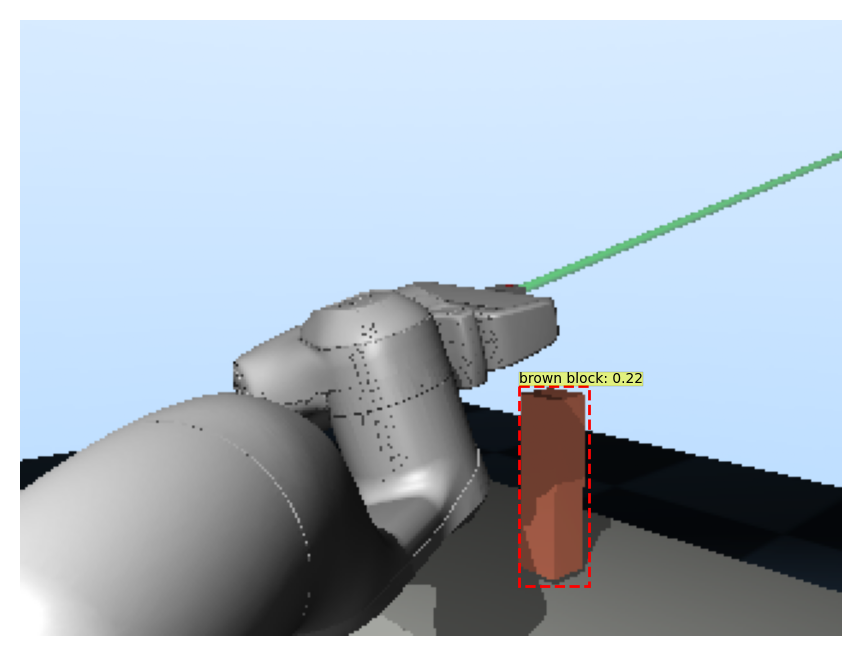

Number of detected boxes: 0
{'scores': tensor([0.2232]), 'labels': tensor([0]), 'boxes': tensor([[194.0307, 141.9975, 221.0927, 220.0194]]), 'object_names': ['brown block'], 'n': 1}


In [6]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.1,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)
print("Number of detected boxes:", len(detection_result.get('rectangular block', [])))
print(detection_result)

In [9]:
# Get point cloud xyz for each detected bounding box
xyz_bboxes = []
for box in detection_result['boxes']:
    # Scale bounding box coordinates to match xyz_img_world resolution
    scale_factor = xyz_img_world.shape[0] / rgb_img.shape[0]
    x1, y1, x2, y2 = (box * scale_factor).int()

    # Extract the 3D points within the bounding box area from xyz_img_world
    xyz = xyz_img_world[y1:y2+1, x1:x2+1, :].reshape(-1, 3)  # [M x 3]
    xyz_bboxes.append(xyz)

# Exclude overlapping point clouds (assuming this function is implemented)
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)

# Get processed object point clouds and their centers
xyz_objects = []
xyz_centers = []
for xyz in xyz_bboxes_unique:
    # Discretize z values to detect floor height robustly
    z_discretized = np.round(xyz[:, 2] / 0.01) * 0.01
    unique, counts = np.unique(z_discretized, return_counts=True)
    k = int(len(unique) * 0.5)  # Use top 50% of height bins for floor detection
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]

    # Estimate floor height and filter points above floor + offset
    z_floor = np.min(top_k_unique_values) + 0.005
    xyz_object = xyz[xyz[:, 2] >= z_floor]
    xyz_objects.append(xyz_object)

    # Fit a circle to the object's xy points to find center and radius
    xy_object = xyz_object[:, :2]
    xy_center, radius = fit_xy_circle(xy_object)
    xyz_centers.append(np.append(xy_center, z_floor))

print("Done.")


Done.


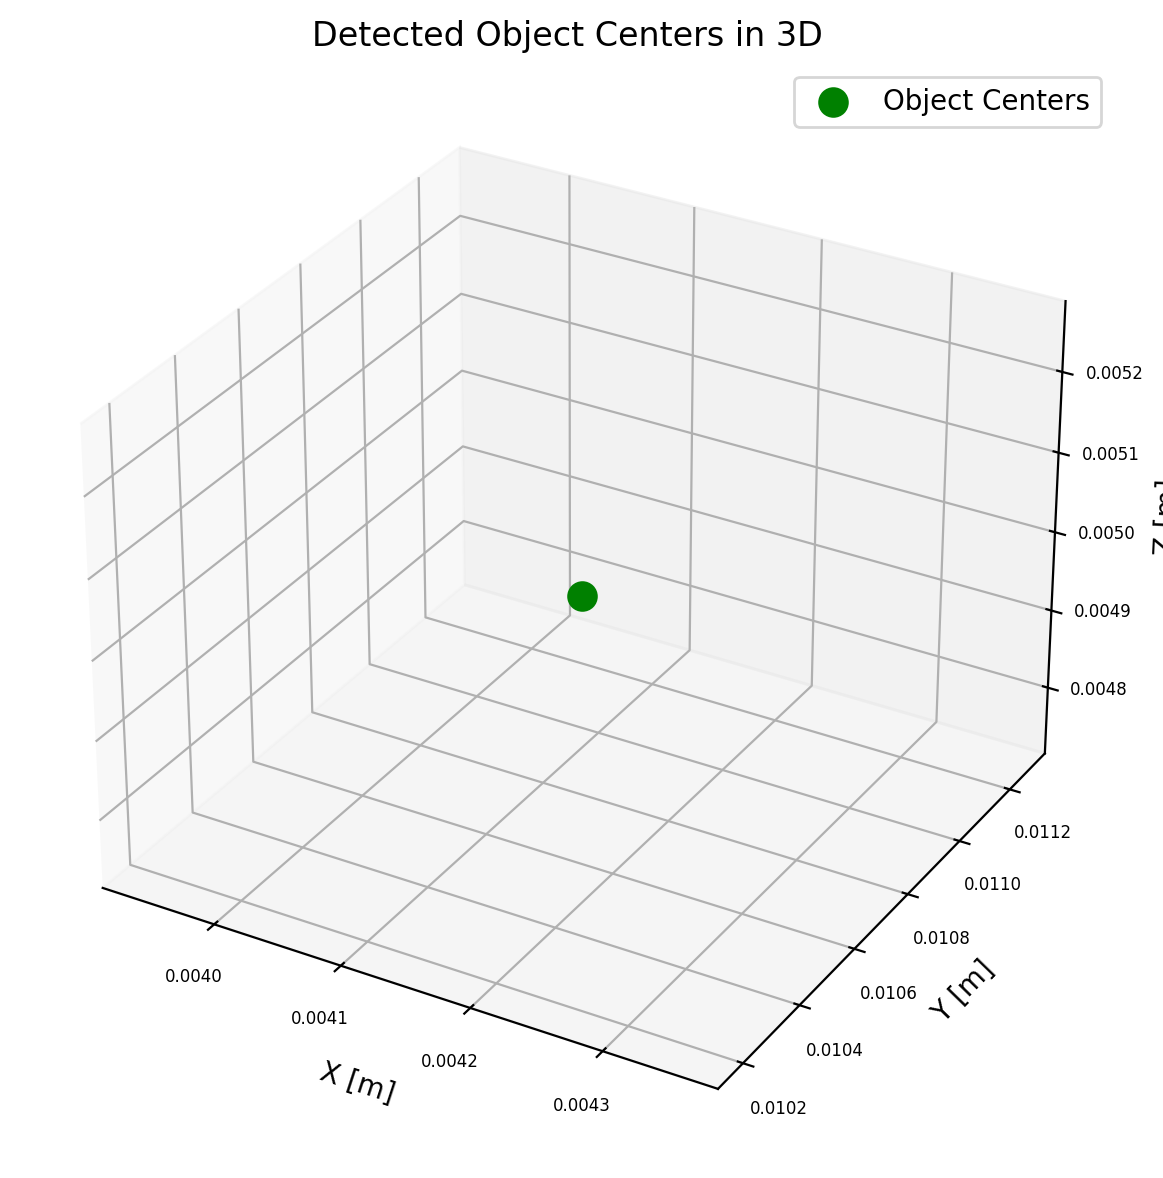

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert list of centers to numpy array for easier handling
xyz_centers_np = np.array(xyz_centers)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the centers as green dots
ax.scatter(xyz_centers_np[:, 0], xyz_centers_np[:, 1], xyz_centers_np[:, 2],
           c='g', s=100, label='Object Centers')

# Set axis labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Detected Object Centers in 3D')

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [10]:
env.reset()
env.set_state(**env_state)
env.init_viewer(azimuth=170,distance=2.3,elevation=-35,lookat=[0.01,0.1,-0.25],
                transparent=True,maxgeom=100000)
while env.is_viewer_alive():
    # Step
    env.step(ctrl=q_init,ctrl_idxs=idxs_step)
    # Render
    if env.loop_every(tick_every=10):
        for idx in range(detection_result['n']):
            env.plot_spheres(ps=xyz_bboxes[idx],r=0.002,rgba=(1,0,0,0.5))
            env.plot_spheres(ps=xyz_objects[idx],r=0.0025,rgba=(0,0,1,0.5))
            env.plot_T(p=xyz_centers[idx],R=np.eye(3),plot_axis=True,axis_len=0.15,axis_width=0.005)
            object_name = detection_result['object_names'][detection_result['labels'][idx]]
            env.plot_text(p=xyz_centers[idx]+np.array([0,0,0.15]),label='%s'%(object_name))
        env.render()
    # Plot
    if env.loop_every(tick_every=5000): # every 10 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1)
        # Plot
        plt.figure(figsize=(6,4))
        plt.imshow(render_img)
        plt.title("Time:[%.2f]sec"%(env.get_sim_time()),fontsize=10)
        plt.axis('off')
        plt.show()
env.close_viewer()
print ("Done.")

NameError: name 'env' is not defined